In [3]:
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
import cv2
import shutil


In [4]:
setup_logger()
dataset_dir = "dataset/"
train_dir = dataset_dir + "train"
val_dir = dataset_dir + "val"
test_dir = dataset_dir + "test"
classes = ["red", "pink", "yellow", "blue", "orange", "green"]
camera_rows = 516
camera_cols = 656

In [5]:
def get_data(img_dir):
    dataset_dicts = []
    for filename in [file for file in os.listdir(img_dir) if file.endswith('.json')]:
        json_file = os.path.join(img_dir, filename)
        with open(json_file) as f:
            img_label = json.load(f)

        record = {}
        
        img = os.path.join(img_dir, img_label["imagePath"])
        
        record["file_name"] = img
        record["height"] = camera_rows
        record["width"] = camera_cols
      
        shapes = img_label["shapes"]
        objs = []
        for shape in shapes:
            px = [a[0] for a in shape['points']]
            py = [a[1] for a in shape['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(shape['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
def get_image_data(img):
    dataset_dicts = []
    json_file = os.path.join(train_dir, img)
    with open(json_file) as f:
        img_label = json.load(f)

    record = {}
        
    img = os.path.join(train_dir, img_label["imagePath"])
        
    record["file_name"] = img
    record["height"] = camera_rows
    record["width"] = camera_cols
      
    shapes = img_label["shapes"]
    objs = []
    for shape in shapes:
        px = [a[0] for a in shape['points']]
        py = [a[1] for a in shape['points']]
        poly = [(x, y) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]

        obj = {
            "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": [poly],
            "category_id": classes.index(shape['label']),
            "iscrowd": 0
        }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
    return dataset_dicts

In [7]:
from detectron2.data.datasets import register_coco_instances
for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d: get_data("dataset/" + d))
    MetadataCatalog.get(d).set(thing_classes=classes)
    register_coco_instances(d, {}, "json_annotation.json", "dataset" + d)

AssertionError: Dataset 'train' is already registered!

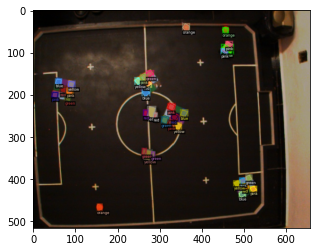

In [10]:
dataset_dicts = get_data(train_dir)
train_metadata = MetadataCatalog.get("train")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[..., ::-1][..., ::-1])

In [11]:
from detectron2.data import detection_utils as utils
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.RandomBrightness(0.6, 1.8),
        T.RandomContrast(0.6, 1.5),
        T.RandomSaturation(0.8, 1.5),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.5),
        T.RandomFlip(prob=0.5),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


In [12]:
NUM_IMG_PER_BATCH = 4


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda"
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.VAL = ("val",)
cfg.DATASETS.TEST = ("val",)
# cfg.DATASETS.TEST = ("test",)
cfg.MODEL.MASK_ON = True
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = NUM_IMG_PER_BATCH
cfg.INPUT.RANDOM_FLIP = "horizontal"
#cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)


In [14]:
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultTrainer
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        custom_mapper = DatasetMapper(cfg, is_train=True, augmentations=[T.RandomFlip(prob=0.7), T.RandomBrightness(0.6, 2.0), T.RandomContrast(0.6, 1.5), T.RandomSaturation(0.8, 1.5), T.RandomLighting(0.8)])
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/14 17:37:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[07/14 17:37:05 d2.engine.train_loop]: Starting training from iteration 0


/home/renan/anaconda3/envs/exameCt213/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/14 17:37:25 d2.utils.events]:  eta: 0:07:02  iter: 19  total_loss: 3.184  loss_cls: 1.17  loss_box_reg: 0.7331  loss_mask: 0.6768  loss_rpn_cls: 0.2045  loss_rpn_loc: 0.3617  time: 0.8854  data_time: 0.0201  lr: 0.00077924  max_mem: 2048M
[07/14 17:37:43 d2.utils.events]:  eta: 0:06:48  iter: 39  total_loss: 2.155  loss_cls: 0.6405  loss_box_reg: 0.6983  loss_mask: 0.4912  loss_rpn_cls: 0.06967  loss_rpn_loc: 0.2562  time: 0.8879  data_time: 0.0065  lr: 0.0015784  max_mem: 2048M
[07/14 17:38:01 d2.utils.events]:  eta: 0:06:31  iter: 59  total_loss: 1.651  loss_cls: 0.4848  loss_box_reg: 0.5888  loss_mask: 0.2933  loss_rpn_cls: 0.06077  loss_rpn_loc: 0.2199  time: 0.8898  data_time: 0.0066  lr: 0.0023776  max_mem: 2048M
[07/14 17:38:19 d2.utils.events]:  eta: 0:06:14  iter: 79  total_loss: 1.244  loss_cls: 0.275  loss_box_reg: 0.4586  loss_mask: 0.243  loss_rpn_cls: 0.05818  loss_rpn_loc: 0.2062  time: 0.8905  data_time: 0.0067  lr: 0.0031768  max_mem: 2048M
[07/14 17:38:37 d2.utils

KeyError: "Dataset 'val' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, train"

In [35]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

[07/14 17:27:34 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [36]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(predictor.model, val_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

FileNotFoundError: [Errno 2] No such file or directory: './output/val_coco_format.json'

In [37]:
i = 0
for d in [file for file in os.listdir(val_dir) if not file.endswith('.json')]:    
    im = cv2.imread(val_dir +"/"+ d)
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("val_" + str(i) + ".jpg", out.get_image()[..., ::-1])
    i += 1

In [38]:
i = 0
for d in os.listdir(test_dir):    
    im = cv2.imread(test_dir + "/" + d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("test_" + str(i) + ".jpg", out.get_image()[..., ::-1])
    i += 1

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [19]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

: 